In [1]:
import random
import os
import numpy as np

random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)  # 파이썬 환경변수 시드 고정
np.random.seed(42)

In [4]:
import pandas as pd

train_features = pd.read_csv("train_features.csv")
train_target = pd.read_csv('train_target.csv')
test_features = pd.read_csv('test_features.csv')

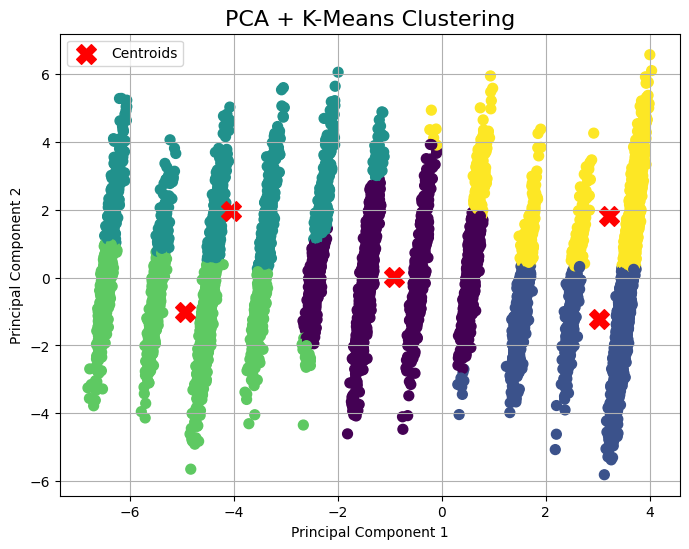

In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# PCA 적용
pca = PCA(n_components=2)  # 2차원으로 축소
reduced_data = pca.fit_transform(train_features)

# K-Means 클러스터링
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(reduced_data)
labels = kmeans.labels_

# 시각화
plt.figure(figsize=(8, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='viridis', s=50)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='red', marker='X', s=200, label='Centroids')
plt.title('PCA + K-Means Clustering', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
train_features['Cluster'] = labels

In [7]:
reduced_test = pca.transform(test_features)
kmeans_test = kmeans.predict(reduced_test)

In [8]:
kmeans_test

array([1, 2, 4, ..., 4, 0, 4], dtype=int32)

In [9]:
test_features['Cluster'] = kmeans_test

In [12]:
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report

def model_report(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    report = classification_report(y_test, y_pred)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'AUC: {auc:.4f}')
    print('Classification Report:')
    print(report)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_features, train_target, test_size=0.2, random_state=42)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

model_report(model, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 0.7010
AUC: 0.7174
Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.90      0.79      1270
           1       0.67      0.36      0.47       730

    accuracy                           0.70      2000
   macro avg       0.69      0.63      0.63      2000
weighted avg       0.69      0.70      0.67      2000



In [14]:
def feature_importance(model, X):
    # 피처 중요도 계산
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]  # 중요도에 따라 정렬

    plt.figure(figsize=(10, 6))
    plt.title("Feature Importance")
    plt.bar(range(X.shape[1]), importances[indices], align='center')
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation=90)
    plt.xlim([-1, X.shape[1]])
    plt.show()

In [16]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 38.0 MB/s eta 0:00:00


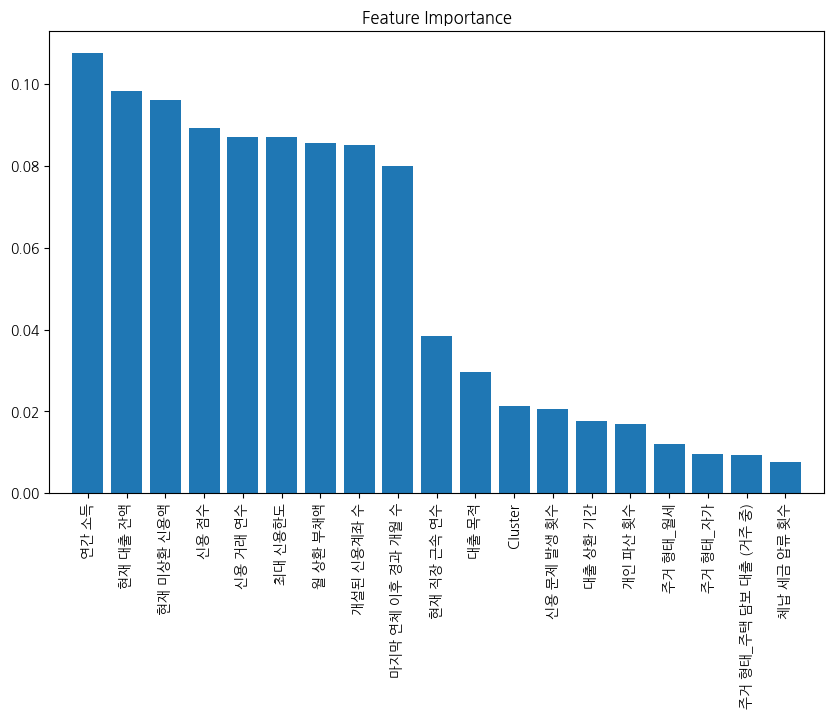

In [18]:
import koreanize_matplotlib

feature_importance(model, X_train)

In [19]:
submit_df = pd.read_csv('sample_submission.csv')

In [20]:
y_pred = model.predict(test_features)

In [21]:
y_pred

array([0, 0, 0, ..., 0, 0, 1])

In [22]:
submit_df['채무 불이행 확률'] = y_pred

In [26]:
from datetime import datetime

def make_submit(test_df, model):
    today = datetime.today().strftime('%Y-%m-%d')
    base_filename = f'submission_{today}.csv'
    filename = base_filename
    counter = 1

    while os.path.exists(filename):
        filename = f'submission_{today}_{counter}.csv'
        counter += 1

    submit_df = pd.read_csv('sample_submission.csv')
    submit_df['채무 불이행 확률'] = model.predict_proba(test_df)[:, 1]
    submit_df.to_csv(filename, index=False)

In [27]:
make_submit(test_features, model)